## 은행 고객 이탈률 예측 (Bank-Customer-Churn-Prediction)

### 1. 문제 정의

#### 1.1 비즈니스 문제 이해
은행 입장에서는 <u>어떤 고객이 곧 이탈할 것인지 아는 것</u>이 매우 중요합니다.

고객 유지는 신규 고객 확보보다 5배 이상 비용 효율적이라는 점에서, 이탈 예측은 핵심 전략이 됩니다.

이탈 고객은 상품 해지, 예금 인출, 경쟁사 이탈로 이어지며, <span style="color:lightblue">수익 감소</span>로 직결됩니다.
따라서 이 분석의 목적은 다음과 같습니다.  

1)이탈 위험이 높은 고객을 조기에 식별   

2)고위험 고객에 대해 마케팅이나 상담, 프로모션 등 사전 대응

 #### 1.2 데이터 기반 문제로 전환 (Analytics Formulation)
비즈니스 문제를 데이터 문제로 바꾸면 이렇게 됩니다:

문제 유형: <span style="color:lightgreen">이진 분류 문제 (Classification)</span>

타깃 변수: Exited (1이면 이탈, 0이면 유지)

입력 변수(Feature): 고객의 정보(지역, 나이, 신용점수, 상품 수 등)

예측 목표: 새로운 고객에 대해 Exited가 1일 확률을 예측하는 것

→ 결국, 주어진 <u>고객 특성을 보고 해당 고객이 이탈할지 아닐지를 예측</u>하는 모델을 만드는 것이 목적입니다.



 #### 1.3 평가 기준 정의
이탈 예측은 단순 정확도보다, 이탈 고객을 얼마나 잘 구분했는지가 더 중요합니다.

그래서 이 대회는 <u>ROC AUC</u>를 평가지표로 사용합니다.

ROC AUC는 민감도(재현율)와 특이도 사이의 Trade-off를 측정

1에 가까울수록 모델이 더 잘 이탈 고객과 유지 고객을 구분

이탈 고객이 드문 상황(class imbalance)에서 유리한 평가 방식



### 2. 데이터 이해 및 전처리

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.font_manager as fm
import platform
import os
import sys

In [22]:
system_name = platform.system()
if system_name == 'Windows':
    # 윈도우의 경우
    plt.rc('font', family='Malgun Gothic') 

In [23]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [24]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


#### <span style="color:Khaki">[변수 설명]  </span> 

##### 1.인구통계학적 변수  

Geography: 고객의 국가/지역 - 지역별 이탈 패턴 차이 확인 가능  
Gender: 성별 - 성별에 따른 이탈 경향 차이 분석  
Age: 나이 - 젊은 층과 노년층의 이탈 패턴 비교  
Surname: 성씨 - 직접적 분석보다는 가족 관계 추론에 활용 가능  

##### 2.금융 관련 변수  

CreditScore: 신용 점수 - 금융 안정성과 이탈의 연관성  
Balance: 계좌 잔액 - 높은/낮은 잔액과 이탈의 관계  
EstimatedSalary: 추정 급여 - 소득 수준과 이탈의 상관관계  

##### 3.은행 관계 관련 변수  

Tenure: 고객 유지 기간(년) - 신규/장기 고객의 이탈 경향 차이  
NumOfProducts: 사용 중인 은행 상품 수 - 상품 다양성과 이탈의 연관성  
HasCrCard: 신용카드 보유 여부 - 신용카드 서비스와 이탈의 관계  
IsActiveMember: 활성 회원 여부 - 활동성과 이탈의 상관관계  

##### 4. 예측 변수 
Exited : 이탈 여부 (0: 유지, 1: 이탈)

In [25]:
train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [26]:
train.isnull().sum() # 결측치가 존재하지 않는다. 

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

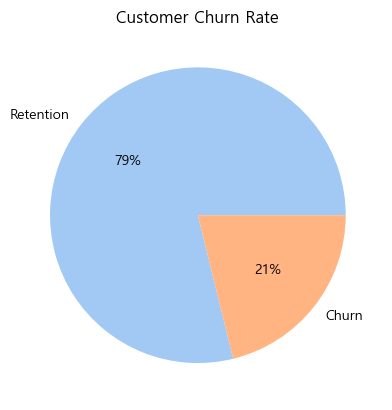

In [27]:

#기존 고객 이탈 여부 파이 차트로 그리기 
colors = sns.color_palette('pastel')

#create pie chart
plt.pie(train['Exited'].value_counts(normalize=True), labels = ['Retention','Churn'], colors = colors, autopct='%.0f%%')
plt.title('Customer Churn Rate')
plt.show()

In [28]:
#변수 기초 통계량 확인 
train.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


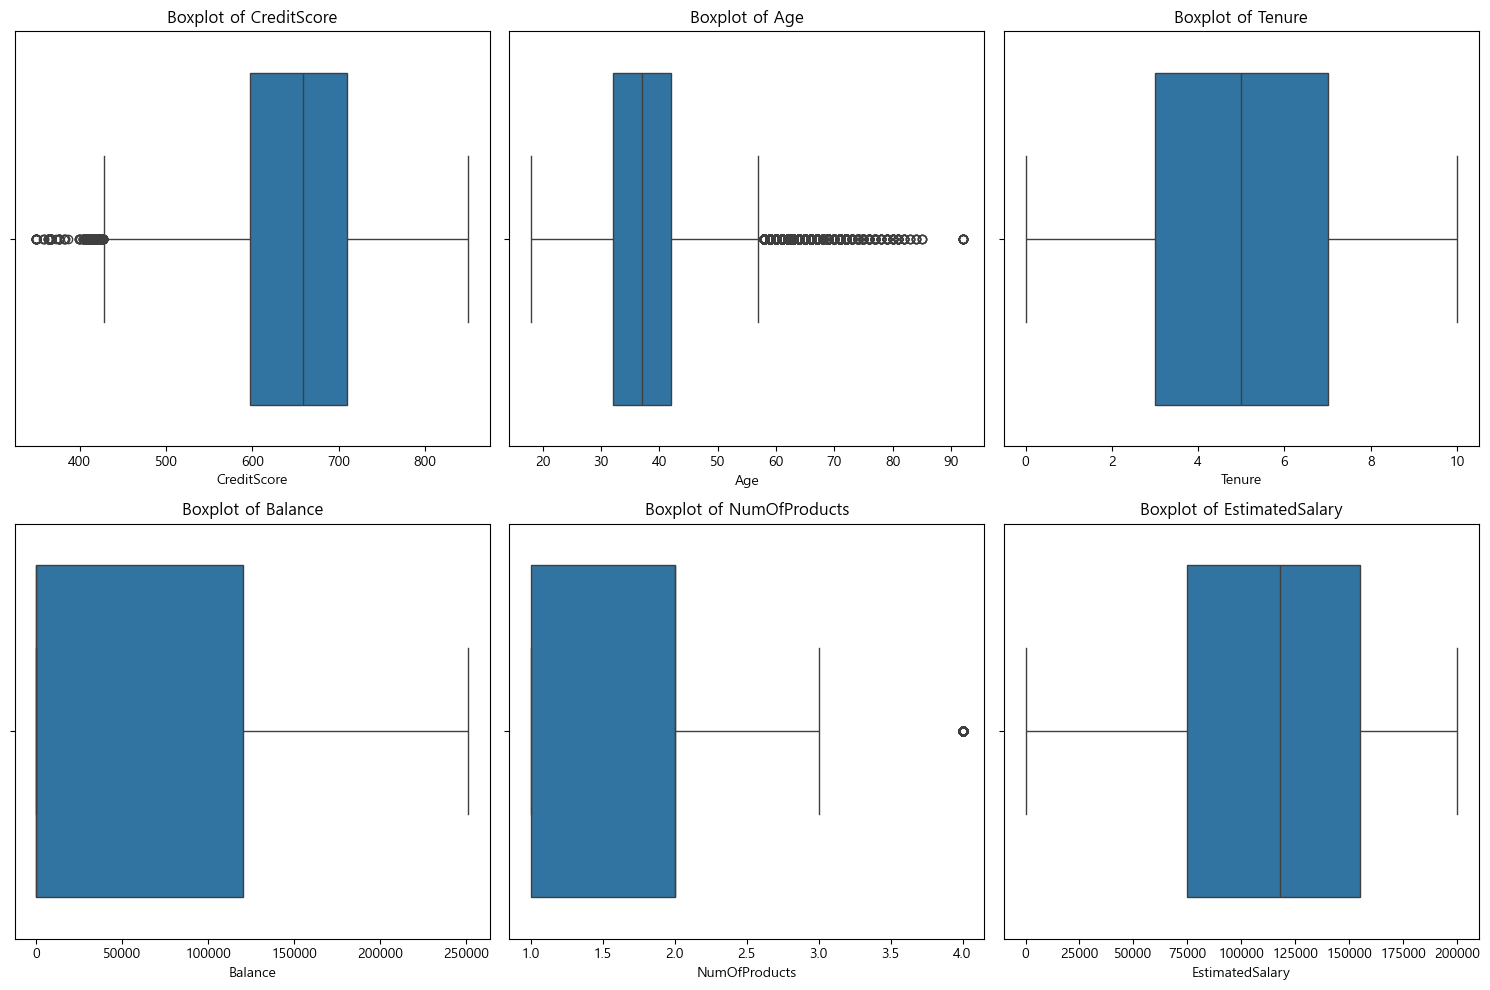

In [29]:
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=train[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
plt.show()

0. 신용점수가 매우 낮은 고객들(이상치)이 보였음.
1. 중앙값은 약 38세, Age 이상치로 봤을 때 고령 고객들에 대한 이탈 가능성 높을 수 있음  
2. 대부분의 고객이 평균적으로 5년 이상 거래함  
3. Balance를 보면 알 수 있듯이 많은 고객들이 예금 없이 유지중, 우측 긴꼬리를 통해 고액 잔액 고객도 일부 존재함 파악 가능
4. 주로 1~2개 상품 보유하는데 4개 상품 보유한 고객(이상치) 존재 
5. 20만달러 이내 범위에 모두 잡히나 1명의 고객이 엄청난 연봉을 보유함(이상치 넘어서 극단치)  

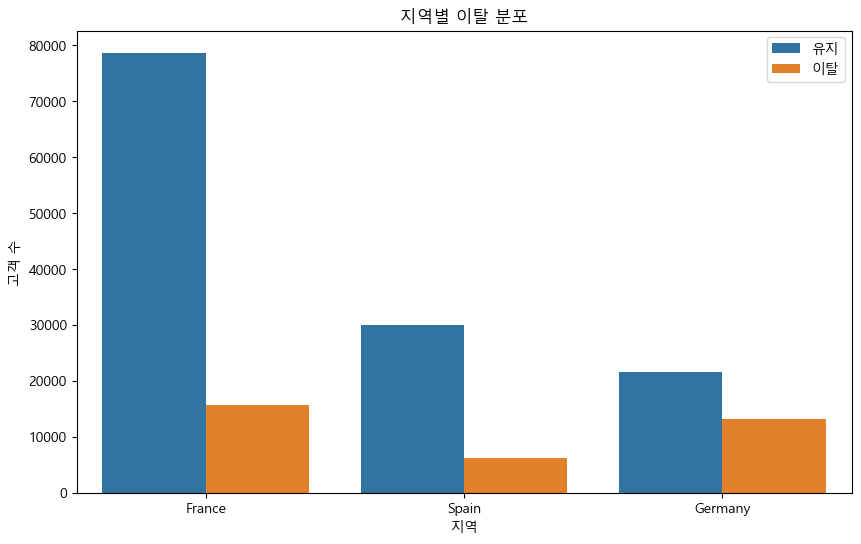

In [30]:
# 지역별 이탈률 시각화
plt.figure(figsize=(10, 6))
sns.countplot(x='Geography', hue='Exited', data=train)
plt.title('지역별 이탈 분포')
plt.xlabel('지역')
plt.ylabel('고객 수')
plt.legend(['유지', '이탈'])
plt.show()

단순 이탈 고객 수는 프랑스가 많으나, 총 고객 대비 이탈 고객 비율은 독일이 크게 나타났음.

### 3. EDA

In [31]:
df = train.copy() 
# 가설검정을 위한 train 데이터 복사본 생성

In [32]:
numerical_vars = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

##### 초기 가설 검정 진행

In [33]:

# 모든 수치형 변수 타입 확인 및 변환
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'HasCrCard', 'IsActiveMember', 'Exited']
for col in numeric_cols:
    df[col] = df[col].astype(float)

# 가설 1: 고령 고객일수록 이탈 가능성이 높을 것이다
print('\n가설 1: 고령 고객일수록 이탈 가능성이 높을 것이다')
age_bins = [0, 30, 40, 50, 60, 100]
age_labels = ['30세 미만', '30-40세', '40-50세', '50-60세', '60세 이상']
age_groups = pd.cut(df['Age'], bins=age_bins, labels=age_labels)
age_churn = pd.crosstab(age_groups, df['Exited'], normalize='index') * 100
age_churn.columns = ['유지(%)', '이탈(%)']
print(age_churn)

# 가설 2: 비활성 회원은 활성 회원보다 이탈률이 높을 것이다
print('\n가설 2: 비활성 회원은 활성 회원보다 이탈률이 높을 것이다')
active_churn = pd.crosstab(df['IsActiveMember'], df['Exited'], normalize='index') * 100
active_churn.index = ['비활성', '활성']
active_churn.columns = ['유지(%)', '이탈(%)']
print(active_churn)

# 가설 3: 특정 지역의 고객은 다른 지역보다 이탈률이 높을 것이다
print('\n가설 3: 특정 지역의 고객은 다른 지역보다 이탈률이 높을 것이다')
geo_churn = pd.crosstab(df['Geography'], df['Exited'], normalize='index') * 100
geo_churn.columns = ['유지(%)', '이탈(%)']
print(geo_churn)



가설 1: 고령 고객일수록 이탈 가능성이 높을 것이다
            유지(%)      이탈(%)
Age                         
30세 미만  91.735079   8.264921
30-40세  87.961484  12.038516
40-50세  61.186833  38.813167
50-60세  39.141391  60.858609
60세 이상  68.575697  31.424303

가설 2: 비활성 회원은 활성 회원보다 이탈률이 높을 것이다
         유지(%)      이탈(%)
비활성  70.291368  29.708632
활성   87.465459  12.534541

가설 3: 특정 지역의 고객은 다른 지역보다 이탈률이 높을 것이다
               유지(%)      이탈(%)
Geography                      
France     83.471846  16.528154
Germany    62.104837  37.895163
Spain      82.782426  17.217574


In [34]:

# 가설 4: 계좌 잔액이 매우 낮거나 매우 높은 고객은 이탈률이 높을 것이다
print('\n가설 4: 계좌 잔액이 매우 낮거나 매우 높은 고객은 이탈률이 높을 것이다')
# Balance가 많은 0값을 가질 수 있으므로, 간단한 cut 함수 사용
min_balance = df['Balance'].min()
max_balance = df['Balance'].max()
balance_bins = [
    min_balance,
    min_balance + (max_balance-min_balance)/5,
    min_balance + 2*(max_balance-min_balance)/5,
    min_balance + 3*(max_balance-min_balance)/5,
    min_balance + 4*(max_balance-min_balance)/5,
    max_balance
]
balance_groups = pd.cut(df['Balance'], bins=balance_bins, labels=['최저', '낮음', '중간', '높음', '최고'])
balance_churn = pd.crosstab(balance_groups, df['Exited'], normalize='index') * 100
balance_churn.columns = ['유지(%)', '이탈(%)']
print(balance_churn)

# 가설 5: 사용 중인 상품 수가 많을수록 이탈 가능성이 낮을 것이다
print('\n가설 5: 사용 중인 상품 수가 많을수록 이탈 가능성이 낮을 것이다')
products_churn = pd.crosstab(df['NumOfProducts'], df['Exited'], normalize='index') * 100
products_churn.columns = ['유지(%)', '이탈(%)']
print(products_churn)


가설 4: 계좌 잔액이 매우 낮거나 매우 높은 고객은 이탈률이 높을 것이다
             유지(%)      이탈(%)
Balance                      
최저       70.243902  29.756098
낮음       78.358105  21.641895
중간       70.882647  29.117353
높음       76.111434  23.888566
최고       67.500000  32.500000

가설 5: 사용 중인 상품 수가 많을수록 이탈 가능성이 낮을 것이다
                   유지(%)      이탈(%)
NumOfProducts                      
1.0            65.288081  34.711919
2.0            93.957837   6.042163
3.0            11.748445  88.251555
4.0            12.421053  87.578947


#### 변수 간 상관관계 분석 

c:\Anaconda3\envs\myenv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()


Text(0.5, 1.0, '변수 간 상관관계 히트맵')

C:\Users\황동민\AppData\Roaming\Python\Python313\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  func(*args, **kwargs)
C:\Users\황동민\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


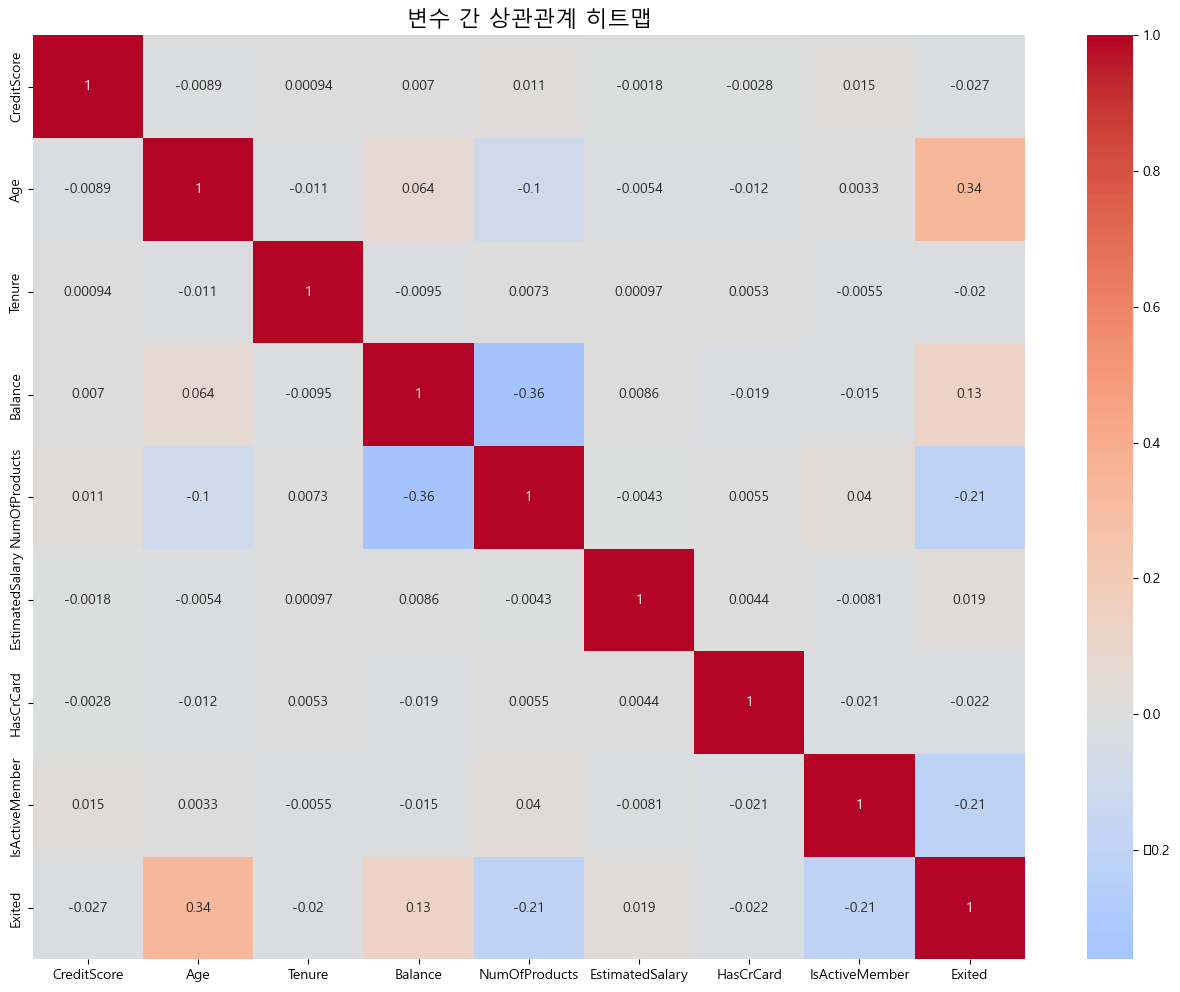

In [35]:
corr_matrix = train[numeric_cols].corr()
plt.figure(figsize=(16, 12))  
sns.heatmap(corr_matrix,annot=True, cmap='coolwarm',center=0)
plt.title('변수 간 상관관계 히트맵', fontsize=16)

ㄴ 특성공학 필요

In [36]:

print('\n[변수 간 강한 상관관계 (절대값 기준 상위 5개)]')
corr_pairs = [(corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]) 
              for i in range(len(corr_matrix)) 
              for j in range(i+1, len(corr_matrix))]

# 절대값 기준 정렬 및 출력
for var1, var2, corr in sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:5]:
    print(f"{var1} - {var2}: {corr:.4f}")


[변수 간 강한 상관관계 (절대값 기준 상위 5개)]
Balance - NumOfProducts: -0.3610
Age - Exited: 0.3408
NumOfProducts - Exited: -0.2146
IsActiveMember - Exited: -0.2102
Balance - Exited: 0.1297


EDA 과정으로 알아볼 수 있었던 것
1. 고령일수록 이탈률 증가  
2. 독일 지역 이탈률 가장 높음
3. 비활성회원 이탈률 뚜렷하게 높음
4. 1개 금융 상품 보유자 이탈률이 가장 높음
5. Balance로는 이탈률 추이 판단 불가능 -> 둘 다 이탈률을 특이하게 가져감

### 4. 다변량 분석을 통한 특성 공학(Feature Engineering) 진행

Text(0.5, 0.98, '지역별 고객 나이와 이탈 관계')

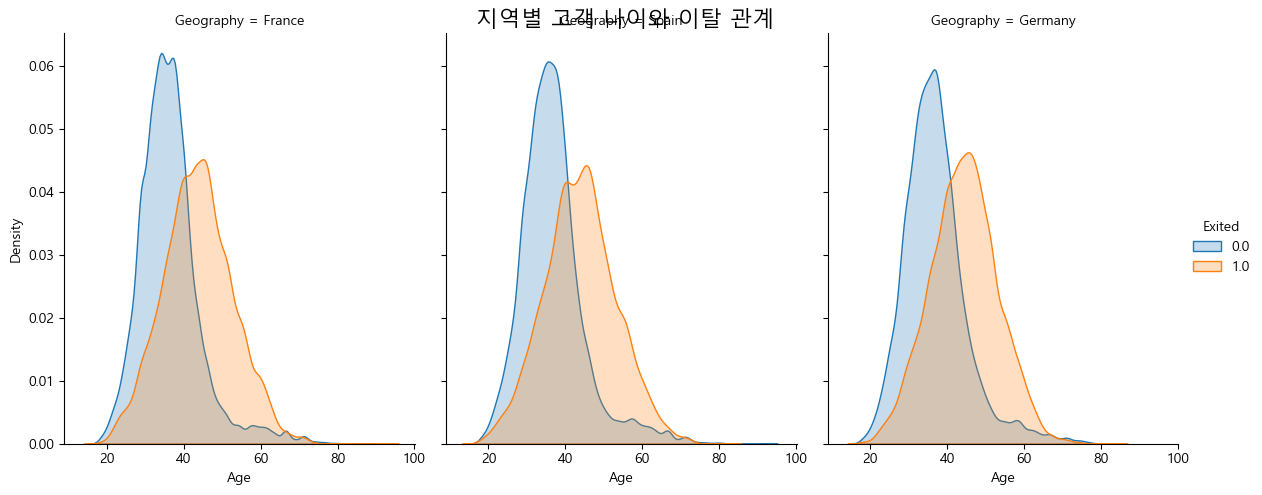

In [37]:
# 지역별 나이와 이탈 관계

g = sns.FacetGrid(df, col='Geography', height=5, aspect=0.8, hue='Exited')
g.map(sns.kdeplot, 'Age', fill=True)
g.add_legend()
plt.suptitle('지역별 고객 나이와 이탈 관계', fontsize=16)

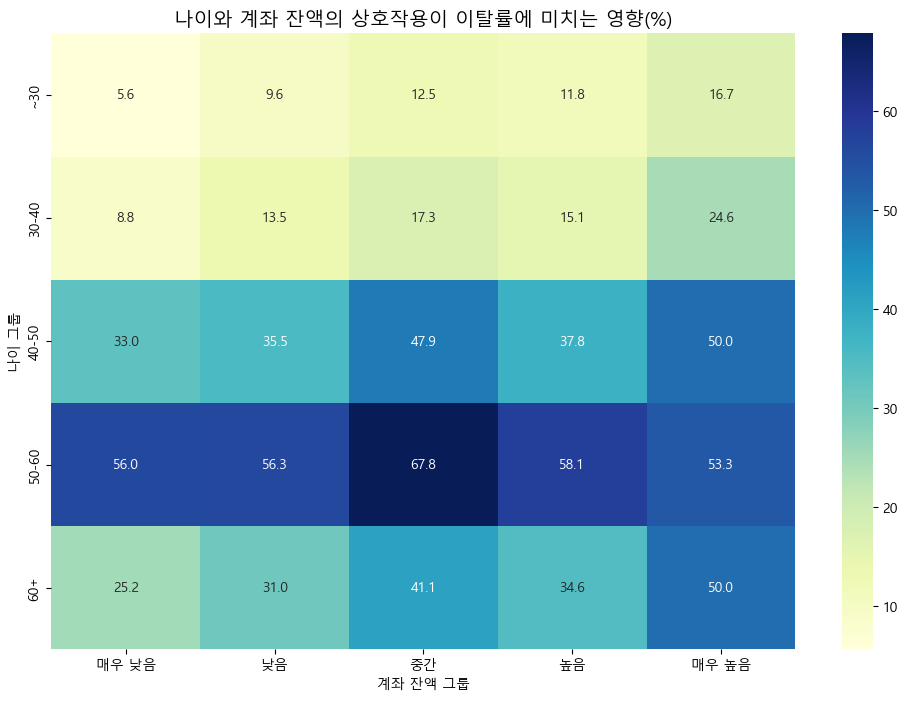

In [38]:
# 나이와 계좌 잔액의 상호작용
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 30, 40, 50, 60, 100], labels=['~30', '30-40', '40-50', '50-60', '60+'])
df['Balance_Group'] = pd.cut(df['Balance'], bins=5, labels=['매우 낮음', '낮음', '중간', '높음', '매우 높음'])

interact_effect = pd.crosstab(
    df['Age_Group'], df['Balance_Group'], 
    values=df['Exited'], aggfunc='mean'
) * 100

plt.figure(figsize=(12, 8))
sns.heatmap(interact_effect, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('나이와 계좌 잔액의 상호작용이 이탈률에 미치는 영향(%)', fontsize=14)
plt.xlabel('계좌 잔액 그룹')
plt.ylabel('나이 그룹')
plt.show()

In [39]:
df = train.copy()

In [40]:
# 파생 변수 생성 및 One-Hot Encoding 진행
df['IsSenior'] = (df['Age'] >= 60).astype(int) # 60세 이상 고객 여부 : 60세라는 사회적 기준(은퇴,  건강 등)을 기준으로 이진화
df['AgeTenureRatio'] = df['Age'] / (df['Tenure'] + 1) #  고령 신입 고객 → 만족도 낮거나 이탈 가능성 ↑ = 나이에 비해 거래기간이 짧으면 높은 값
df['InactiveHighBalance'] = ((df['IsActiveMember'] == 0) & (df['Balance'] > 100000)).astype(int) # 활동하지 않지만 잔액은 높은 고객 = 잠재적 고위험 고객
df['IsMinimalUser'] = (df['NumOfProducts'] == 1).astype(int) # 1개 상품만 보유한 고객 = 1 → 이탈 가능성이 높은 미약한 사용자군

# 범주형 변수에 대한 더미 데이터 생성 
df = pd.get_dummies(df, columns=['Gender', 'Geography'], drop_first=True)

df.drop(columns=['id', 'CustomerId', 'Surname'], inplace=True)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CreditScore          165034 non-null  int64  
 1   Age                  165034 non-null  float64
 2   Tenure               165034 non-null  int64  
 3   Balance              165034 non-null  float64
 4   NumOfProducts        165034 non-null  int64  
 5   HasCrCard            165034 non-null  float64
 6   IsActiveMember       165034 non-null  float64
 7   EstimatedSalary      165034 non-null  float64
 8   Exited               165034 non-null  int64  
 9   IsSenior             165034 non-null  int64  
 10  AgeTenureRatio       165034 non-null  float64
 11  InactiveHighBalance  165034 non-null  int64  
 12  IsMinimalUser        165034 non-null  int64  
 13  Gender_Male          165034 non-null  bool   
 14  Geography_Germany    165034 non-null  bool   
 15  Geography_Spain  

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     26023
           1       0.71      0.53      0.61      6984

    accuracy                           0.86     33007
   macro avg       0.80      0.74      0.76     33007
weighted avg       0.85      0.86      0.85     33007

ROC AUC Score: 0.8707


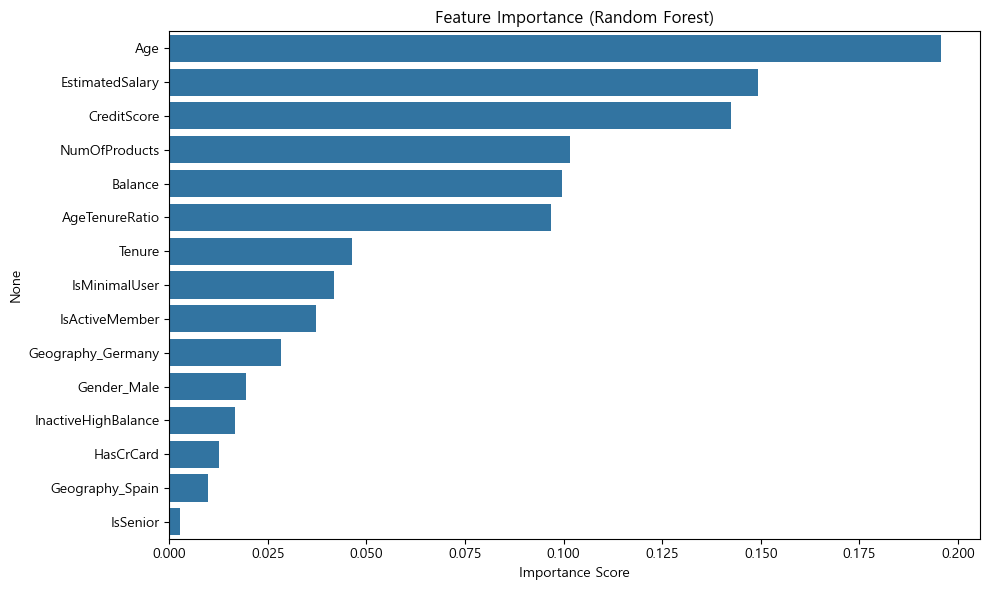

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report


# 4. 입력(X), 타깃(y) 분리
X = df.drop('Exited', axis=1)
y = df['Exited']
# 5. 학습/검증 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 6. 모델 훈련
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 7. 예측 및 평가
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# 8. 피처 중요도 시각화
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

[결과 해석]
1. 전체 예측 정확도(Accuracy)는 89%로 상당히 높음  
2. ROC AUC는 0.9246로 매우 우수한 분류 성능을 보임.  
3. 재현율(Recall)이 낮아서 일부 이탈자를 놓치고 있음. 
4. 실제 이탈자(Precision)은 78%로 예측한 이탈자 중 78%는 실제 이탈자임을 의미함. 

특성공학 검증 결과:  

IsSenior, InactiveHighBalance는 중요도 낮음 → <span style="color:coral"> 제거 </span>

AgeTenureRatio, IsMinimalUser는 높은 기여도 → <span style="color:skyblue"> 유지 </span>

In [44]:
df.drop(columns=['IsSenior','InactiveHighBalance'], inplace=True) # 불필요한 파생변수 제거

##### 연속형 변수 표준화(Scaling)

In [45]:
from sklearn.preprocessing import StandardScaler

In [46]:
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [47]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,AgeTenureRatio,IsMinimalUser,Gender_Male,Geography_Germany,Geography_Spain
0,0.144135,-0.578074,-0.719973,-0.883163,2,1.0,0.0,1.369486,0,8.250000,0,True,False,False
1,-0.367706,-0.578074,-1.432694,-0.883163,2,1.0,1.0,-1.254085,0,16.500000,0,True,False,False
2,0.268974,0.211354,1.774548,-0.883163,2,1.0,0.0,1.437422,0,3.636364,0,True,False,False
3,-0.941966,-0.465299,-1.076334,1.486918,1,1.0,1.0,-0.557018,0,11.333333,1,True,False,False
4,0.743362,-0.578074,-0.007253,-0.883163,2,1.0,1.0,-1.938770,0,5.500000,0,True,False,True


In [49]:
# 1. 범주형 타입 정수화
df[['Gender_Male', 'Geography_Germany', 'Geography_Spain']] = df[['Gender_Male', 'Geography_Germany', 'Geography_Spain']].astype(int)

# 2. 타깃 변수 정수화
df['Exited'] = df['Exited'].astype(int)


이제 모델링을 위한 데이터 준비가 완료되었습니다. 